# Characterization of IBMQ devices using Qiskit Pulse

Based on:

- [Calibrating Qubits with Qiskit Pulse](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html) (Qiskit textbook)

- [Relaxation and Decoherence](https://qiskit.org/documentation/tutorials/noise/2_relaxation_and_decoherence.html) (Qiskit documentation)

- [Building Pulse Schedules](https://qiskit.org/documentation/tutorials/circuits_advanced/06_building_pulse_schedules.html) (Qiskit documentation)

- [Qiskit Aer: Pulse simulation of two qubits using a Duffing oscillator model](https://qiskit.org/documentation/tutorials/circuits_advanced/09_pulse_simulator_duffing_model.html) (Qiskit documentation)

- [Learn quantum computing with python and IBM quantum experience](https://github.com/PacktPublishing/Learn-Quantum-Computing-with-Python-and-IBM-Quantum-Experience/blob/master/Chapter11/Chapter%2011%20-%20Ignis.ipynb) (chapter 11 of the book - 'Ignis')

- [An introduction to open quantum systems](https://github.com/qiskit-community/qiskit-textbook/blob/master/content/ch-quantum-hardware/Open-quantum-systems.ipynb) (unfinished Qiskit notebook)



## Utilities

### Installation

In [ ]:
!pip install 'qiskit[visualization]' --quiet
save_and_load = True

     |████████████████████████████████| 6.0MB 6.5MB/s 
     |████████████████████████████████| 18.0MB 154kB/s 
     |████████████████████████████████| 235kB 55.6MB/s 
     |████████████████████████████████| 215kB 54.3MB/s 
     |████████████████████████████████| 2.1MB 37.2MB/s 
     |████████████████████████████████| 163kB 49.7MB/s 
     |████████████████████████████████| 1.5MB 30.2MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 194kB 46.5MB/s 
     |████████████████████████████████| 71kB 9.1MB/s 
     |████████████████████████████████| 614kB 29.9MB/s 
     |████████████████████████████████| 3.2MB 27.1MB/s 
     |████████████████████████████████| 6.3MB 28.7MB/s 


### Basic imports and backend qubit defaults

In [ ]:
import random, time, os, shutil, numpy as np, matplotlib.pyplot as plt, pickle
from pathlib import Path
from scipy.optimize import curve_fit
from google.colab import files
from qiskit import execute
from qiskit import pulse            
from qiskit.pulse import Play
from qiskit.pulse import library as pulse_lib
from qiskit.ignis.characterization.calibrations import rabi_schedules,RabiFitter
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

from qiskit import IBMQ
API_KEY = 'd1e0708e9ea899bf5a17e43c1b948223b9c9b66e19dfb58a40fc20b0ee383b8595ef447b340a57fa6e3b9da49c9711efbec30a8a68c77ab235e42662cbba1a62'

if save_and_load: # First time run.
  IBMQ.save_account(API_KEY, overwrite=True)
  IBMQ.load_account()
  save_and_load = False

# Channel delays seem to have to be multiples of 16 for >1 qubit backends?
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

specific_choice = None #'ibmq_guadalupe'
nqubits = 1
exclude = None

mock_backend = False
if mock_backend:
  from qiskit.providers.aer import PulseSimulator
  from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk
  from qiskit.providers.aer.pulse import PulseSystemModel
  armonk_backend = FakeArmonk()
  armonk_model = PulseSystemModel.from_backend(armonk_backend)
  backend = PulseSimulator()
  # Must change functions too. See https://qiskit.org/documentation/tutorials/circuits_advanced/10_pulse_simulator_backend_model.html
elif nqubits is not None and nqubits==1:
  provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
  backend = provider.get_backend('ibmq_armonk')
  print("Selected single qubit backend: ", backend, end="")
elif specific_choice is not None:
  provider=IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
  backend = provider.get_backend(specific_choice)
  print("Selected backend: ", backend, end="")
else:
  provider=IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
  conditional_backends = provider.backends(filters=lambda x: 
                            (nqubits is None or x.configuration().n_qubits==nqubits)
                            and not x.configuration().simulator 
                            and x.configuration().backend_name != exclude
                            and x.configuration().open_pulse is True)
  backend = least_busy(conditional_backends,reservation_lookahead=2*60)
  print("Selected least busy backend: ", backend,end="")


q = 0 # The index of the qubit to be considered.

defaults = backend.defaults()
properties = backend.properties()
time_unit = properties.gate_length("id", [q])
print(" (time resolution: %.2f ns)" % (time_unit*1e9))
configuration = backend.configuration()
job_limit = backend.job_limit()
maxjobs = job_limit.maximum_jobs
print("Maximum pending jobs allowed per user: ", 
      "no limit" if maxjobs is None else maxjobs)
print(configuration.to_dict())

t1_est = properties.t1(q)
t2_est = properties.t2(q)
freq_est = properties.frequency(q) 
# ^Same as backend.defaults().qubit_freq_est[0] which is the default for driving
#channel.

print("The estimated backend properties for qubit %d are:" % q)
print("* Resonance frequency: %.2f gigahertz" % (freq_est*1e-9))
print("* T1 time: %.1f microseconds" % (t1_est*1e6))
print("* T2 time: %.1f microseconds" % (t2_est*1e6))

Selected single qubit backend:  ibmq_armonk (time resolution: 71.11 ns)
Maximum pending jobs allowed per user:  5
{'backend_name': 'ibmq_armonk', 'backend_version': '2.4.11', 'n_qubits': 1, 'basis_gates': ['id', 'rz', 'sx', 'x'], 'gates': [{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0]]}, {'name': 'rz', 'parameters': ['theta'], 'qasm_def': 'gate rz(theta) q { U(0, 0, theta) q; }', 'coupling_map': [[0]]}, {'name': 'sx', 'parameters': [], 'qasm_def': 'gate sx q { U(pi/2, 3*pi/2, pi/2) q; }', 'coupling_map': [[0]]}, {'name': 'x', 'parameters': [], 'qasm_def': 'gate x q { U(pi, 0, pi) q; }', 'coupling_map': [[0]]}], 'local': False, 'simulator': False, 'conditional': False, 'open_pulse': True, 'memory': True, 'max_shots': 8192, 'coupling_map': None, 'dynamic_reprate_enabled': False, 'supported_instructions': ['measure', 'setf', 'rz', 'shiftf', 'u3', 'u1', 'u2', 'acquire', 'x', 'delay', 'sx', 'play', 'id'], 'max_experiments': 75, 'sample_name

### Data collection functions

For gathering organized data for the inference, and saving to files. 

Will be used when gathering data for the inference, in the sections:

- [*Running a Ramsey experiment*](#ramsey)
- [*Running an echoed Ramsey experiment (using opposite detunings)*](#echoed_ramsey)
- [*Performing a Hahn Echo experiment to get an estimate of T2*](#T2)
- [*Performing an experiment to get the energy relaxation time T1*](#T1)

In [ ]:
def get_params_header(times,job):
    results = job.result().get_counts()
    p0s = [0 if '0' not in result else result['0']/sum(result.values()) 
          for result in results]
    y0,ymin = p0s
    model_params = y0-ymin, ymin 
    header = ("params", model_params)
    print("Const")
    return header

def assemble_data_vector(times, job, header):
    result = job.result(timeout=120)
    results = result.get_counts()
    data = [] if header is None else [header]

    for i,dict in enumerate(results):
        # Shuffle each count because otherwise 0 results always come first
        #(undesirable for the inference).
        new_data = []
        for key in dict:
            outcome = int(key)
            # Use times in microseconds.
            datum = (times[i]*1e6,outcome)
            new_data.extend([datum for shot in range(dict[key])])
        random.shuffle(new_data)
        data.extend(new_data)
    return data

def data_to_file(job, times, filename_start, index, header, folder_name):
  data = assemble_data_vector(times, job, header)
  filename = filename_start + ('_%d.data' % index)
  print("Run %d data vector (length %d): " % (index,len(data)), data)
  with open(Path(folder_name + "/" + filename), 'wb') as filehandle:
      pickle.dump(data, filehandle)
  #files.download(filename)

def times_to_file(times, filename_start, folder_name):
  filename = filename_start + '_finish_times.data'
  print("* Finish times vector (length %d): " % len(times), times)
  with open(Path(folder_name + "/" + filename), 'wb') as filehandle:
      pickle.dump(times, filehandle)
  #files.download(filename)

def collect_data(job_function, times, runs, nshots, filename_start, 
                 adapt_params_obj = None, job_list = None, 
                 register_times = False):
  '''
  'adapt_params_obj' signals whether additional higher shot measurements
  should be performed with the purpose of adjusting the model parameters. 
  If it is not None, it should contain a tuple of times and a shot number,
  with the form ((t0,tmax),nshots).

  This can be used to calibrate the offset and coordinate at the origin for
  the T1 and T2 experiments. The first time should then be zero, and the last
  should be long compared to the estimated characteristic time. 
  
  A header with the form ("params", (A,B)) will precede the other data in the
  data vector.
  '''
  # Create a folder to contain all the data files, so we can zip and download it 
  #later.
  folder_name = filename_start
  path = Path(folder_name)
  os.mkdir(path)

  header = None

  if job_list is not None:
      print(" Will use the %d jobs from list given [collect_data]." % 
            len(job_list))
      for i,job_ID in enumerate(job_list):
          job = backend.retrieve_job(job_ID)
          job_monitor(job)
          download_data(job, times, filename_start, i, header, folder_name)
      return

  if adapt_params_obj is not None:
      edge_times, edge_shots = adapt_params_obj
      print("Getting adapted parameters for header... [collect_data]")
      edge_job = job_function(np.array(edge_times),nshots=edge_shots,
                              monitor=True)
      header = get_params_header(edge_times, edge_job)

  if register_times is True:
    finish_times = []
  jobs = []
  i, j = 0, 0 # Counters for submitted and collected jobs respectively.
  try:
      # Submit maximum parallel jobs allowed per user in the backend.
      for c in range(min(runs,float('inf') if maxjobs is None 
                         else (maxjobs - job_limit.active_jobs))): 
          print("> Run %d." % i)
          job = job_function(times,nshots=nshots,monitor=False)
          jobs.append(job)
          i += 1
      # Retrieve oldest submitted when possible and submit next: will queue 1 more 
      #job (next 'i' up) when allowed, and download jth's data.
      while i<runs:
          job_monitor(jobs[0]) # Blocking instruction.
          if register_times:
            finish_times.append(time.time())
          # When oldest submitted and unretrieved has finished:
          data_to_file(jobs[0], times, filename_start, j, header, folder_name)
          # Remove the one already arranged into a data vector and submit 1 more.
          jobs = jobs[1:]; j += 1
          job = job_function(times,nshots=nshots,monitor=False)
          jobs.append(job); i += 1
      # Retrieve leftover jobs if they exist.
      while j<runs:
          job_monitor(jobs[0]) # Wait for completion.
          data_to_file(jobs[0], times, filename_start, j, header, folder_name)
          if register_times:
            finish_times.append(time.time())
          jobs = jobs[1:]; j += 1
  except KeyboardInterrupt:
      print("Quit due to keyboard interrupt.")

  if register_times:
    times_to_file(finish_times, filename_start, folder_name)
    
  # !zip -r /content/data.zip /content
  zip_name = filename_start
  shutil.make_archive(zip_name, 'zip', folder_name)
  files.download(zip_name + '.zip')

In [ ]:
def collect_data_wait(job_function, times, runs, nshots, filename_start, 
                 adapt_params_obj = None, job_list = None):
  '''
  Wait for each job to run, in order to register a more precise estimate of
  the starting time. This one always registers the times.
  '''
  # Create a folder to contain all the data files, so we can zip and download it 
  #later.
  folder_name = filename_start
  path = Path(folder_name)
  os.mkdir(path)

  header = None

  if job_list is not None:
      print(" Will use the %d jobs from list given [collect_data]." % 
            len(job_list))
      for i,job_ID in enumerate(job_list):
          job = backend.retrieve_job(job_ID)
          job_monitor(job)
          download_data(job, times, filename_start, i, header, folder_name)
      return

  if adapt_params_obj is not None:
      edge_times, edge_shots = adapt_params_obj
      print("Getting adapted parameters for header... [collect_data]")
      edge_job = job_function(np.array(edge_times),nshots=edge_shots,
                              monitor=True)
      header = get_params_header(edge_times, edge_job)

  finish_times = []
  i = 0
  while (i < runs):
      try:
          print("> Run %d." % i)
          job = job_function(times,nshots=nshots,monitor=False)
          while(str(job.status())!='JobStatus.RUNNING'):
            pass
          finish_times.append(time.time()) # Starting time.
          job_monitor(job)
          data_to_file(job, times, filename_start, i, header, folder_name)
      except KeyboardInterrupt:
        print("\n>Quit due to keyboard interrupt.")
        break
      except:
          err = sys.exc_info()[0]
          print("> Error at run %d (%s)." % (i,err))
          continue
      i += 1

  times_to_file(finish_times, filename_start, folder_name)
  # !zip -r /content/data.zip /content
  zip_name = filename_start
  shutil.make_archive(zip_name, 'zip', folder_name)
  files.download(zip_name + '.zip')

In [ ]:
while(str(job.status())!='JobStatus.RUNNING'):
  pass
t1 = time.time() # Starting time.
while(str(job.status())!='JobStatus.DONE'):
  job_monitor(job,quiet=True)
t2 = time.time() # Finishing time.

## Determining T1 from experiments (using a Qiskit fitter)

T1 job ID: '60b911a5e6595b4717bfac78'
Job Status: job has successfully run
Estimated parameters for model P(1)=A.exp(-t/T1)+B:
* A  = 0.70 ± 0.01
* T1 = 71.84 ± 3.77 microseconds
* B  = 0.19 ± 0.02
(Estimated backend T1 is 48.69 microseconds.)


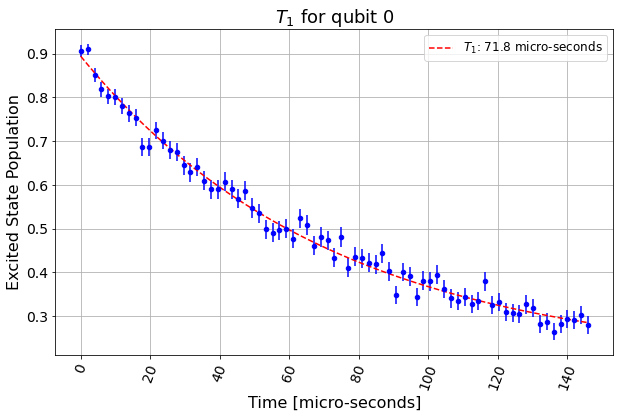

In [ ]:
from qiskit.ignis.characterization.coherence import t1_circuits, T1Fitter

run_again = True
if run_again:
    ngates = np.linspace(0, 3*t1_est/time_unit, 75, dtype='int')
    gate_time = time_unit*1e6 # In microseconds.
    t1_circs, t1_delays = t1_circuits(ngates, gate_time, [q])
    t1_job = execute(t1_circs, backend, shots=512)
    print(f"T1 job ID: \'{t1_job.job_id()}\'")
else:
    t1_job = backend.retrieve_job('60b7bbe19af47d6e4e2d1caf')
    # Paris, np.linspace(0, 2*t1_est/time_unit, 75, dtype='int')
job_monitor(t1_job)
t1_result = t1_job.result()

# Parameters by order (A,T1,B) for P(1)=A*e**(-t/T1)+B
t1_fit = T1Fitter(t1_result, t1_delays, [q],
                  fit_p0=[1, t1_est*1e6, 0],
                  fit_bounds=([0, 0, 0], [1, 2*t1_est*1e6, 1]))

print("Estimated parameters for model P(1)=A.exp(-t/T1)+B:")
labels = ["A ","T1","B "]
# First zero to index qubit from all measured (1), second to extract single list.
params = t1_fit.params['0'][0]
errors = t1_fit.params_err['0'][0]
for i in range(len(params)):
    print("* %s = %.2f ± %.2f" % (labels[i],params[i],errors[i]),end="")
    extra = " microseconds" if str(labels[i])[0]=='T'else ""
    print(extra)
print(f"(Estimated backend T1 is {round(t1_est*1e6,2)} microseconds.)")

fig,ax = plt.subplots(figsize=(10, 6))
t1_fit.plot(0,ax=ax)
plt.show()

## Determining T2 from experiments (using a Qiskit fitter)

T2 job ID: '60c264074f8f1182df81e55a'
Job Status: job has successfully run
Estimated parameters for model P(0)=A.exp(-t/T2)+B:
* A  = 0.43 ± 0.01
* T2 = 52.39 ± 3.69 microseconds
* B  = 0.53 ± 0.01
(Estimated backend T2 is 57.58 microseconds.)


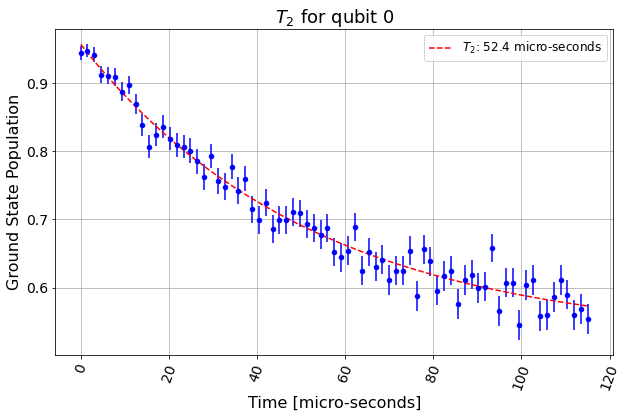

In [ ]:
from qiskit.ignis.characterization.coherence import t2_circuits, T2Fitter

run_again = True
if run_again:
    ngates = np.linspace(0, 2*t2_est/(2*time_unit), 75, dtype='int')
    gate_time = time_unit*1e6 # In microseconds.
    t2_circuits, t2_delays = t2_circuits(ngates, gate_time, [q])

    t2_job = execute(t2_circuits, backend, shots=512,optimization_level=0)
    print(f"T2 job ID: \'{t2_job.job_id()}\'")
    job_monitor(t2_job)
else:
    #t2_job = backend.retrieve_job('60b66e594c7440e1ed3ff1c9') # 1024 shots.
    #t2_job = backend.retrieve_job('60b67105d48a832c7e9790b7') # 20 shots.
    #t2_job = backend.retrieve_job('60b6786c7a767885789f839c') # 512 shots.
    # All 3 with t2_est = 76.51 (Rome, 01/06), (0,4000,75)
    t2_job = backend.retrieve_job('60b7a92201804785e39153f1') # 512 shots.
    

t2_result = t2_job.result()

# Parameters by order (A,T2,B) for P(0)=A*exp(-t/T2)+B
t2_fit = T2Fitter(t2_result, t2_delays, [q], 
                      fit_p0=[0.5, t2_est*1e6, 0.5], 
                      fit_bounds=([0, 0, 0], [1, 2*t2_est*1e6, 1]),
                      time_unit='micro-seconds')

print("Estimated parameters for model P(0)=A.exp(-t/T2)+B:")
labels = ["A ","T2","B "]
# First zero to index qubit from all measured (1), second to extract single list.
params = t2_fit.params[str(0)][0] 
errors = t2_fit.params_err[str(0)][0]
for i in range(len(params)):
    print("* %s = %.2f ± %.2f" % (labels[i],params[i],errors[i]),end="")
    extra = " microseconds" if str(labels[i])[0]=='T'else ""
    print(extra)
print(f"(Estimated backend T2 is {round(t2_est*1e6,2)} microseconds.)")

fig,ax = plt.subplots(figsize=(10, 6))
t2_fit.plot(0,ax=ax)
plt.show()

## Determining T2* from experiments (using a Qiskit fitter)

Job Status: job has successfully run
49.07648205757141
T2* job ID: '60d34d90573ead18a87f283c'
Estimated parameters for model P(0)=A.exp(-t/T2).cos(2.pi.f.t+φ)+B:
* A   = 0.47 ± 0.01
* T2* = 4.26 ± 0.26 microseconds
* f   = 2.03 ± 0.00
* phi = 0.04 ± 0.04
* B   = 0.51 ± 0.00


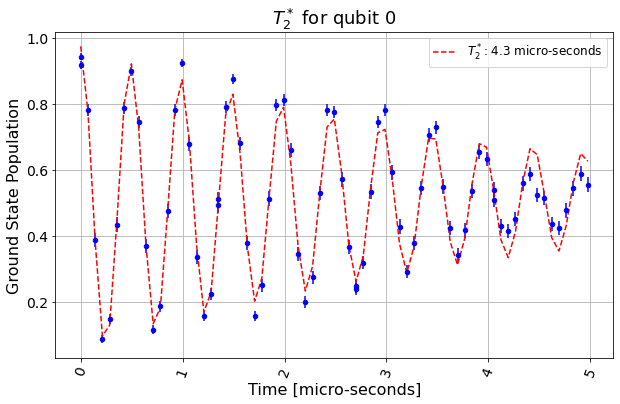

In [ ]:
from qiskit.ignis.characterization.coherence import t2star_circuits, T2StarFitter

ngates_star = np.linspace(0, 5e-6/time_unit, 75, dtype='int')
gate_time = time_unit*1e6
t2star_circs, t2star_delays, osc_freq = \
                          t2star_circuits(ngates_star, gate_time, [q], nosc=10)

run_again = True
if run_again:

    t2star_job = execute(t2star_circs, backend, shots=512, optimization_level=0)

    '''
    To time (~ 50 seconds for 75 ngates, 512 shots)
    while(str(t2star_job.status())!='JobStatus.RUNNING'):
        pass
    t0 = time.time()
    job_monitor(t2star_job)
    print(time.time()-t0)
    '''

    print(f"T2* job ID: \'{t2star_job.job_id()}\'")
    job_monitor(t2star_job)
else:
    t2star_job = backend.retrieve_job('60cdffacf10da2f6434e03cc')
    # np.linspace(10, 100, 50, dtype='int') for 6099773f016639105426250e
t2star_result = t2star_job.result()

t2star0 = 10

#Parameters by order (A,T2*,f,phi,B) for P(1)=A.exp(-t/T2*)*cos(2pi*f*t+phi)+B
t2star_fit = T2StarFitter(t2star_result, t2star_delays, [q],
                          fit_p0=[0.5, t2star0, osc_freq, 0, 0.5],
                          fit_bounds=([0, 0, 0, 0, 0],
                                      [1, 100, 2*osc_freq, 2*np.pi, 1]),
                          time_unit='micro-seconds')

print("Estimated parameters for model P(0)=A.exp(-t/T2).cos(2.pi.f.t+φ)+B:")
labels = ["A  ","T2*","f  ","phi","B  "]
params = t2star_fit.params[str(q)][0]
errors = t2star_fit.params_err[str(q)][0]
for i in range(len(params)):
    print("* %s = %.2f ± %.2f" % (labels[i],params[i],errors[i]),end="")
    extra = " microseconds" if str(labels[i])[0]=='T'else ""
    print(extra)

fig,ax = plt.subplots(figsize=(10, 6))
t2star_fit.plot(0,ax=ax)
plt.show()

In [ ]:
t2star_job = backend.retrieve_job('60d09757f80e3a5b109ea87e')
job_monitor(t2star_job)

Job Status: job is queued (1)

KeyboardInterrupt: ignored

## Calibrating pulses

Creating personalized pi ($σ_x$) and half-pi (*H*) pulses by doing a Rabi experiment (amplitude sweep to determine the wave half-period).

### Getting the pulse amplitude with a Rabi experiment

/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Rabi job ID: '60bbdee09cd20ef5d48597cb' [run_rabi_job]
Job Status: job has successfully run


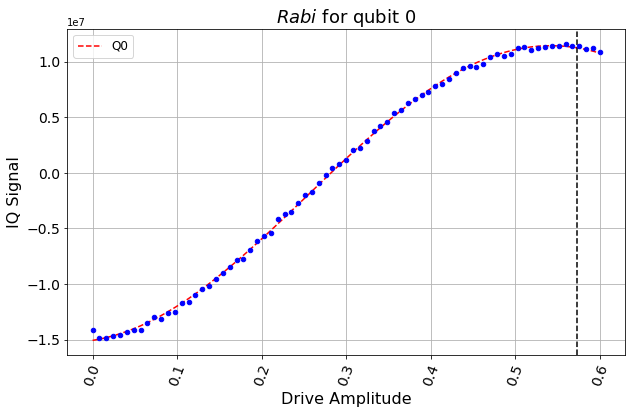

Pi pulse amplitude: 0.5724310310942751


In [ ]:
def run_rabi_job(drive_amps, drive_sigma, drive_duration):
    # List of drive channels.
    drive_channel = pulse.DriveChannel(q)
    drive_channels = [drive_channel]

    # Get the schedules.
    rabi_sched, amps = rabi_schedules(amp_list=drive_amps,
                           qubits=[q],
                           pulse_width=drive_duration,
                           pulse_sigma=drive_sigma,
                           drives=drive_channels,
                           inst_map=backend.defaults().instruction_schedule_map,
                           meas_map=backend.configuration().meas_map)

    rabi_job = backend.run(rabi_sched,
                    #schedule_los=[{drive_channel: freq_est}]*len(drive_amps),
                    meas_level=1,
                    meas_return='avg',
                    shots=8192)
    ID = rabi_job.job_id()
    print(f"Rabi job ID: \'{ID}\' [run_rabi_job]")
    job_monitor(rabi_job)
    return(rabi_job)

def get_pi_pulse_amplitude(rabi_job, amps, show=False):
    rabi_results = rabi_job.result()
    rabi_fit = RabiFitter(rabi_results, amps, [q], 
                          fit_p0 = [3.5e14, 2, 0.5, -0.5e14])
    pi_amp = rabi_fit.pi_amplitude(0)
    if show:
        fig,ax = plt.subplots(figsize=(10, 6))
        rabi_fit.plot(q, ax=ax)
        plt.show()
        print(f"Pi pulse amplitude: {pi_amp}")
    return(pi_amp)

run_again = True
if run_again:
    # Pick the parameters for the gaussian drive pulses (width + truncation).
    # Durations (in samples) should be the same as used in the Rabi schedules.
    drive_sigma = 8
    drive_duration = 8*16 # Should be a multiple of 16.
    amps = np.linspace(0, 0.6, 75)
    rabi_job = run_rabi_job(amps, drive_sigma, drive_duration)
else:
    drive_sigma = 8
    drive_duration = 8*16 # Should be a multiple of 16.
    amps = np.linspace(0, 0.4, 75)
    job_ID = '60bbaf70a8e98d7c49bcc4ca'
    rabi_job = backend.retrieve_job(job_ID)
    
pi_amp = get_pi_pulse_amplitude(rabi_job, amps, show=True)

### Defining custom pulses 

These are necessarily if building the schedules from scratch, which allows for improved precision; if this is not necessary, the default pulse instructions can be used instead.

In [ ]:
'''
These will be necessary later if building schedules instead of using the 
default pulses from the pulse builder interface.
Method 0 gives pulses (waveforms), method 1 gives schedules. The former can be
used as an argument to Pulse.Play(), the latter in the pulse.call() 
construction. 
'''

def get_pi_pulse(method=1):
    if method==0:
        pi_pulse = pulse_lib.gaussian(duration=drive_duration,
                                      amp=pi_amp, 
                                      sigma=drive_sigma,
                                      name='pi')
    else:
        inst_sched_map = defaults.instruction_schedule_map
        pi_pulse = inst_sched_map.get('x',qubits=[q])
    return pi_pulse

def get_half_pi_pulse(method=1):
    if method==0:
        half_pi_amp = pi_amp/2
        drive_durationII = get_closest_multiple_of_16(drive_duration/2)
        half_pi_pulse = pulse_lib.gaussian(duration=drive_durationII,
                                            amp=half_pi_amp, 
                                            sigma=drive_sigma,
                                            name='half_pi')
    else:
        inst_sched_map = defaults.instruction_schedule_map
        half_pi_pulse = inst_sched_map.get('u2',[q],0,np.pi)
    return half_pi_pulse

def get_measure_pulse():
    inst_sched_map = defaults.instruction_schedule_map
    measure = inst_sched_map.get('measure',qubits=[q])
    # Includes stimulus + acquisiton.
    return measure

### Testing the pulses

In [ ]:
 measure = get_measure_pulse() 
 pi_pulse = get_pi_pulse(method=0)
 half_pi_pulse = get_half_pi_pulse(method=0)
 dq = pulse.DriveChannel(q)

schedule0 = pulse.Schedule(name="|0>")
schedule0 += measure

hschedule = pulse.Schedule(name="|+>")
hschedule += Play(half_pi_pulse, dq)  
hschedule += measure << hschedule.duration

schedule1 = pulse.Schedule(name="|1>")
schedule1 += Play(pi_pulse, dq)  
schedule1 += measure << schedule1.duration

run_again = False
if run_again:
    job = backend.run([schedule0, hschedule, schedule1],
                              meas_level=2,
                              shots=2048)
    print("Job ID: \'%s\'." % job.job_id())
    job_monitor(job)
else:
    job = backend.retrieve_job('60bbcca4a8e98d02ebbcc64d')

result = job.result()

p0s = []
for count_dict in result.get_counts():
  p0 = 0
  for key in count_dict:
    if key[-1]=='0':
      p0 += count_dict[key]
  p0 = p0/len(count_dict)
  p0s.append(p0)

print("Preparation-measurement rates:")
print("- Measured 0 after a pi pulse:       %.1f%%" % ((p0s[2])*100))
print("- Measured 0 after a half pi pulse: %.1f%%" % ((p0s[1])*100))
print("- Measured 0 after no pulses:       %.1f%%" % (p0s[0]*100))

Preparation-measurement rates:
- Measured 0 after a pi pulse:       9.9%
- Measured 0 after a half pi pulse: 50.1%
- Measured 0 after no pulses:       90.9%


In [ ]:
with pulse.build(backend) as hschedule_def:
  with pulse.align_sequential():
    pulse.u2(0,np.pi,q)
    pulse.call(measure)  

with pulse.build(backend) as schedule1_def:
  with pulse.align_sequential():
    pulse.x(q)
    pulse.call(measure)

run_again = False
if run_again:
    job = backend.run([hschedule_def, schedule1_def],
                              meas_level=2,
                              shots=2048)
    print("Job ID: \'%s\'." %job.job_id())
    job_monitor(job)
else:
    job = backend.retrieve_job('60bbacc01c8d4f39291fdce3')

result = job.result()

p0s = []
for count_dict in result.get_counts():
  p0 = 0
  for key in count_dict:
    if key[-1]=='0':
      p0 += count_dict[key]
  p0 = p0/len(count_dict)
  p0s.append(p0)

print("Preparation-measurement rates:")
print("- Measured 0 after a pi pulse:      %.1f%%" % ((p0s[1])*100))
print("- Measured 0 after a half pi pulse: %.1f%%" % ((p0s[0])*100))

Preparation-measurement rates:
- Measured 0 after a pi pulse:      11.2%
- Measured 0 after a half pi pulse: 50.8%


## <a name="ramsey"></a>Running a Ramsey experiment

In [ ]:
def get_ramsey_schedules(ts, delta_f, method=2):
    # Need to convert evolution times to backend time units/samples.
    with pulse.build(backend):
      samples = pulse.builder.seconds_to_samples(ts)
    delays = np.array([get_closest_multiple_of_16(nsamples) 
                       for nsamples in samples])

    if method<2:
        half_pi = get_half_pi_pulse(q,defaults) 
        measure = get_measure_pulse(q,defaults) 
        drive_channel = pulse.DriveChannel(q)
    else:
        mq = pulse.MeasureChannel(q)
    ramsey_schedules = []
    
    for i,delay in enumerate(delays):
        if method==0:
              schedule = pulse.Schedule(name=f"Ramsey delay no. {i}")
              schedule += pulse.Play(half_pi, drive_channel)
              schedule += pulse.Delay(int(delay),drive_channel)
              schedule += pulse.Play(half_pi, drive_channel)
              schedule += pulse.Delay(int(schedule.duration),mq)
              schedule += measure
        elif method==1:
              schedule = pulse.Schedule(name=f"Ramsey delay no. {i}")
              schedule += pulse.Play(half_pi, drive_channel)
              # Delays/time shifts must be integers, so round these together.
              second_pulse_start = int(schedule.duration + delay) 
              schedule |= pulse.Play(half_pi, drive_channel) << second_pulse_start
              # Have to shift measure instructions because the channel is parallel.
              schedule += measure << int(schedule.duration) 
        elif method==2:
              with pulse.build(backend,name=f"Delay no. {i}") as schedule:
                with pulse.align_sequential():
                  pulse.u2(0,np.pi,q) # Half pi rotation.
                  # Delay can be in any channel assuming sequential alignment.
                  if delay != 0: # This should make no difference, but it does
                    pulse.delay(delay,mq) 
                  pulse.u2(0,np.pi,q) 
                  pulse.measure(q)
        ramsey_schedules.append(schedule)
    #ramsey_schedules[4].draw()
    return ramsey_schedules

def run_ramsey_job(ts, delta_f, nshots=512, monitor=True):
    ramsey_schedules = get_ramsey_schedules(ts, delta_f)
    ramsey_frequency = freq_est + delta_f
    drive_channel = pulse.DriveChannel(q)
    # We'll override the default pulse frequencies to use the intended one.
    frequencies = [{drive_channel: ramsey_frequency} 
                   for i in range(len(ramsey_schedules))]
    ramsey_job = backend.run(ramsey_schedules,meas_level=2,shots=nshots,
                             schedule_los=frequencies)
    ID = ramsey_job.job_id()
    print(f"Ramsey job ID: '{ID}' [run_ramsey_job]")
    if monitor:
        job_monitor(ramsey_job)
        
    return ramsey_job

import time
run_again = False
if run_again:
    delta_f = 1.83e6
    ts = np.linspace(0, 5e-6, 75) # The actual times in seconds.
    ramsey_job = run_ramsey_job(ts, delta_f)
else:
    delta_f = 1.83e6
    ts = np.linspace(0, 5e-6, 75)
    #ramsey_job = backend.retrieve_job('60b93be0f120a76097b8fafb')
    ramsey_job = backend.retrieve_job('60d11c674efaf715fc402a30')

### Fitting a curve

Decaying likelihood curve fit:
* f  = 1.876539 ± 0.005590 MHz
* T2* = 4.487815 ± 0.713820 us


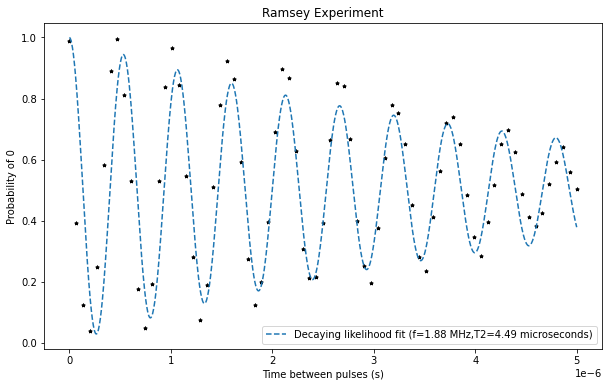

In [ ]:
def get_ramsey_values():
    ramsey_results = ramsey_job.result()
    ramsey_values = []
    results = ramsey_results.get_counts()
    for result in results:
        ramsey_values.append(0 if '0' not in result else 
                             result['0']/sum(result.values()))
    return(ramsey_values)

def decaying_likelihood(t, f, T2, model_params):
    A,B = model_params
    return A*np.exp(-t/T2)*np.cos(2*np.pi*f*t/2)**2+B-np.exp(-t/T2)/2

def fit_likelihood(ts, values, model_params, smoothen_interpolation=True, print_param=True):
    p0=[delta_f,10e-6]
    parameters,cov = curve_fit(lambda t,f,T2: decaying_likelihood(t,f,T2,model_params), 
                         ts, values, p0=p0)
    f,T2 = parameters
    ferr, T2err = np.sqrt(np.diag(cov))
    if print_param:
        print("Decaying likelihood curve fit:\n* f  = %.6f ± %.6f MHz\n"
              "* T2* = %.6f ± %.6f us"  % (f*1e-6,ferr*1e-6,T2*1e6,T2err*1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = decaying_likelihood(ts, *parameters, model_params)
    
    return parameters,ts,ys

def correct_frequency(offset=False):
    ramsey_values = get_ramsey_values()
    pmax = ramsey_values[0] if offset else 1
    (observed_f,_),_,_ = fit_likelihood(ts,ramsey_values,model_params,print_param=False)
    corrected_f = freq_est + (observed_f - delta_f)
    print("The backend frequency estimate was           %.8f GHz.\n" 
          "The Ramsey experiment yielded a frequency of %.8f GHz." 
          % (freq_est/1e9,corrected_f/1e9))
    return corrected_f

def plot_ramsey_fit(adapt_params = False):
    ramsey_values = get_ramsey_values()
    y0,offs = [ramsey_values[0], ramsey_values[-1]] if adapt_params else [1,0.5]
    model_params = y0,offs
    if adapt_params:
        print("Used model parameters A=%.2f, B=%.2f. " % 
              (model_params[0],model_params[1]))
        # Use the last measurement for the offset only.
        times, ramsey_values = ts[:-1], ramsey_values[:-1]
    else:
        times = ts

    '''
    ramsey_values = get_ramsey_values()
    ramsey_values = ramsey_values[:-1]
    times = ts[:-1]
    pmax = ramsey_values[0] if offset else 1
    '''
    (f,T2),extended_ts,ys = fit_likelihood(times,ramsey_values,model_params)
    plt.figure(figsize=(10, 6))
    plt.scatter(times, ramsey_values, s=12, color='black', marker='*')
    curve_label = ("Decaying likelihood fit (f=%.2f MHz,T2=%.2f microseconds)" % 
                   (f/1e6,T2*1e6))
    plt.plot(extended_ts,ys,linestyle='dashed',label=curve_label)
    plt.title("Ramsey Experiment")
    plt.xlabel('Time between pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()

plot_ramsey_fit()

### Comparing the curve fit to the inference results

Decaying likelihood curve fit:
* f  = 1.876539 ± 0.005590 MHz
* T2* = 4.487815 ± 0.713820 us


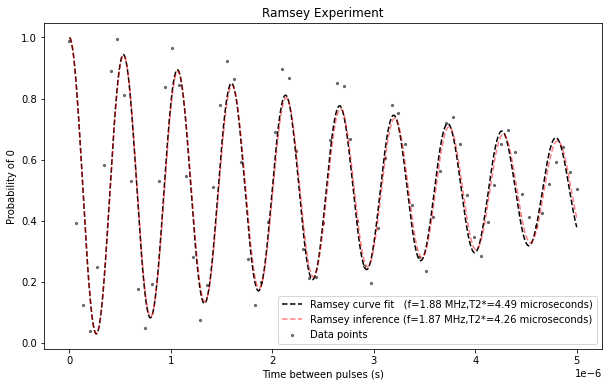

In [ ]:
def compare_inference(inference_params = [1.87,4.26]):
    model_params = [1,0.5]
    ramsey_values = get_ramsey_values()
    (f,T2),extended_ts,ys = fit_likelihood(ts,ramsey_values,model_params)
    f2, T22 = inference_params
    f2, T22 = f2*1e6, T22*1e-6
    y2s = decaying_likelihood(extended_ts, f2, T22, model_params)

    plt.figure(figsize=(10, 6))
    plt.scatter(ts, ramsey_values, color='black',s=5,alpha=0.5,label='Data points')
    curve_label = ("Ramsey curve fit   (f=%.2f MHz,T2*=%.2f microseconds)" % 
                   (f/1e6,T2*1e6))
    curve_label2 = ("Ramsey inference (f=%.2f MHz,T2*=%.2f microseconds)" % 
                   (f2/1e6,T22*1e6))
    plt.plot(extended_ts,ys,color='black', linestyle='dashed',label=curve_label)
    plt.plot(extended_ts,y2s,color='red', linestyle='dashed',label=curve_label2,alpha=0.5)
    plt.title("Ramsey Experiment")
    plt.xlabel('Time between pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()

compare_inference()

### Getting data for the inference

In [ ]:
delta_f = 1.83e6
tmin, tmax = 1e-6, 5e-6
nsched = 75; nshots = 2; runs = 100
rand = False
if rand:
  times = np.array([random.uniform(tmin,tmax) for i in range(nsched)])
else:
  times = np.linspace(tmin, tmax, nsched)

filename_start = configuration.backend_name[5:] + '_ramsey_data_ts[' +     \
    str(round(tmin*1e6*2,1)) + ',' +  str(round(tmax*1e6)) + '[' +      \
    'f=' + str(round(delta_f*1e-6,2))  + ('(rand)' if rand else '') +\
    '_sched=' + str(nsched) + '_nshots=' + str(nshots)

# collect_data(lambda ts,nshots,monitor: run_ramsey_job(ts,delta_f, nshots=nshots,
#                                                       monitor=monitor), 
#              times, runs, nshots, filename_start,register_times = True)

collect_data_wait(lambda ts,nshots,monitor: run_ramsey_job(ts,delta_f, nshots=nshots,
                                                      monitor=monitor), 
             times, runs, nshots, filename_start)

> Run 0.
Ramsey job ID: '60d127b7f80e3ac1919eb082' [run_ramsey_job]
Job Status: job has successfully run
Run 0 data vector (length 150):  [(1.0, 0), (1.0, 0), (1.054054054054054, 0), (1.054054054054054, 0), (1.1081081081081081, 1), (1.1081081081081081, 0), (1.162162162162162, 1), (1.162162162162162, 0), (1.2162162162162162, 1), (1.2162162162162162, 1), (1.2702702702702704, 0), (1.2702702702702704, 1), (1.3243243243243243, 1), (1.3243243243243243, 1), (1.3783783783783785, 0), (1.3783783783783785, 0), (1.4324324324324325, 1), (1.4324324324324325, 0), (1.4864864864864866, 0), (1.4864864864864866, 0), (1.5405405405405403, 0), (1.5405405405405403, 0), (1.5945945945945947, 1), (1.5945945945945947, 0), (1.6486486486486485, 0), (1.6486486486486485, 0), (1.7027027027027029, 1), (1.7027027027027029, 0), (1.7567567567567568, 1), (1.7567567567567568, 1), (1.810810810810811, 0), (1.810810810810811, 1), (1.864864864864865, 1), (1.864864864864865, 1), (1.918918918918919, 1), (1.918918918918919, 1), (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## <a name="echoed_ramsey"></a>Running an echoed Ramsey experiment (using opposite detunings)

Prolongs the coherence time $T_2^*$.

Based on [Fault-tolerant Hahn-Ramsey interferometry with pulse sequences of alternating detuning](https://www.physik.uni-siegen.de/quantenoptik/forschung/publikationen/publis/hahn_ramsey.pdf).

In [ ]:
def get_echoed_ramsey_schedules(ts, delta_f):
    # Need to convert evolution times to backend time units/samples.
    with pulse.build(backend):
      samples = pulse.builder.seconds_to_samples(ts/2)
    delays = np.array([get_closest_multiple_of_16(nsamples) 
                       for nsamples in samples])
    
    ramsey_schedules = []
    dq = pulse.DriveChannel(q)
    mq = pulse.MeasureChannel(q)
    for i,delay in enumerate(delays):
        with pulse.build(backend,name=f"Delay no. {i}") as schedule:
          with pulse.align_sequential():
            pulse.set_frequency(freq_est + delta_f, dq)
            pulse.u2(0,np.pi,q) # Half pi rotation.
            pulse.delay(delay,mq)
            pulse.set_frequency(freq_est - delta_f, dq)
            pulse.x(q) # Pi rotation.
            pulse.delay(delay,mq)
            pulse.set_frequency(freq_est + delta_f, dq)
            pulse.u2(0,np.pi,q) 
            pulse.measure(q)  
        ramsey_schedules.append(schedule)
    return ramsey_schedules

def run_echoed_ramsey_job(ts, delta_f, nshots=512, monitor=True):
    ramsey_schedules = get_echoed_ramsey_schedules(ts, delta_f)
    echoed_ramsey_job = backend.run(ramsey_schedules,meas_level=2,shots=nshots)
    ID = echoed_ramsey_job.job_id()
    print(f"Echoed ramsey job ID: '{ID}' [run_echoed_ramsey_job]")
    if monitor:
        job_monitor(echoed_ramsey_job)
    return echoed_ramsey_job

delta_f = 1.83e6
run_again = True
if run_again: 
    ts = np.linspace(0, 4e-6, 75) # The actual times in seconds.
    echoed_ramsey_job = run_echoed_ramsey_job(ts,delta_f)
else:
    ts = np.linspace(0, 4e-6, 50) # The actual times in seconds.
    echoed_ramsey_job = backend.retrieve_job('60a513aeb9b3524989d2802b')

Echoed ramsey job ID: '60d0f32c6af67936975c57bd' [run_echoed_ramsey_job]
Job Status: job has successfully run


### Fitting a curve

In [ ]:
def get_ramsey_values():
    ramsey_results = echoed_ramsey_job.result()
    ramsey_values = []
    results = ramsey_results.get_counts()
    for result in results:
        ramsey_values.append(result['0']/sum(result.values()))
    return(ramsey_values)

def decaying_likelihood(t, f, T2, pmax):
    return pmax*(np.exp(-t/T2)*np.cos(2*np.pi*f*t/2)**2+(1-np.exp(-t/T2))/2)

def fit_likelihood(ts, values, pmax, smoothen_interpolation=True, print_param=True):
    p0=[delta_f,10e-6]
    parameters,cov = curve_fit(lambda t,f,T2: decaying_likelihood(t,f,T2,pmax), 
                         ts, values, p0=p0)
    f,T2 = parameters
    ferr, T2err = np.sqrt(np.diag(cov))
    if print_param:
        print("Decaying likelihood curve fit:\n* f  = %.6f ± %.6f MHz\n"
              "* T2* = %.6f ± %.6f us"  % (f*1e-6,ferr*1e-6,T2*1e6,T2err*1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = decaying_likelihood(ts, *parameters, pmax)
    
    return parameters,ts,ys

def plot_ramsey_fit(adapt_params = False):

    ramsey_values = get_ramsey_values()
    pmax = ramsey_values[0] if offset else 1
    (f,T2),extended_ts,ys = fit_likelihood(ts,ramsey_values,pmax)
    plt.figure(figsize=(10, 6))
    plt.scatter(ts, ramsey_values, s=12, color='black', marker='*')
    curve_label = ("Decaying likelihood fit (f=%.2f MHz,T2=%.2f microseconds)" % 
                   (f/1e6,T2*1e6))
    plt.plot(extended_ts,ys,linestyle='dashed',label=curve_label)
    plt.title("\"Hahn-Ramsey\" Experiment")
    plt.xlabel('Time between π/2 pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()

plot_ramsey_fit()

NameError: ignored

### Comparing the curve fit to the inference results

Decaying likelihood curve fit:
* f  = 1.827853 ± 0.000670 MHz
* T2* = 24.495239 ± 2.608171 us


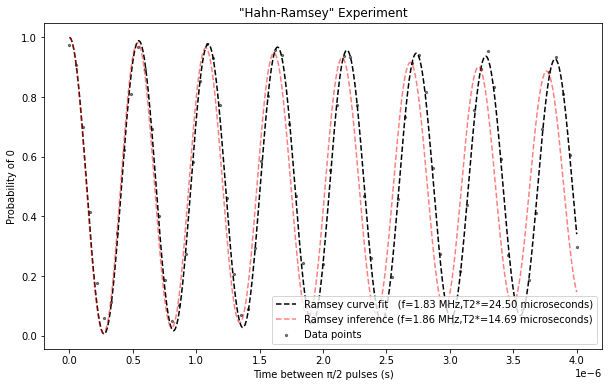

In [ ]:
def compare_inference(inference_params = [1.86,14.69]):
    pmax = 1
    ramsey_values = get_ramsey_values()
    (f,T2),extended_ts,ys = fit_likelihood(ts,ramsey_values,pmax)
    f2, T22 = inference_params
    f2, T22 = f2*1e6, T22*1e-6
    y2s = decaying_likelihood(extended_ts, f2, T22, pmax)

    plt.figure(figsize=(10, 6))
    plt.scatter(ts, ramsey_values, color='black',s=5,alpha=0.5,label='Data points')
    curve_label = ("Ramsey curve fit   (f=%.2f MHz,T2*=%.2f microseconds)" % 
                   (f/1e6,T2*1e6))
    curve_label2 = ("Ramsey inference (f=%.2f MHz,T2*=%.2f microseconds)" % 
                   (f2/1e6,T22*1e6))
    plt.plot(extended_ts,ys,color='black', linestyle='dashed',label=curve_label)
    plt.plot(extended_ts,y2s,color='red', linestyle='dashed',label=curve_label2,alpha=0.5)
    plt.title("\"Hahn-Ramsey\" Experiment")
    plt.xlabel('Time between π/2 pulses (s)')
    plt.ylabel('Probability of 0')
    plt.legend(loc='lower right')
    plt.show()

compare_inference()

### Getting data for the inference

In [ ]:
delta_f = 1.83e6
tmin, tmax = 0.2e-6, 2e-6
nsched = 30; nshots = 1; runs = 100
rand = False
if rand:
  times = np.array([random.uniform(tmin,tmax) for i in range(nsched)])
else:
  times = np.linspace(tmin, tmax, nsched)

filename_start = configuration.backend_name[5:] + '_echoed_ramsey_data[' +    \
    str(round(tmin*1e6,1)) + ',' +  str(round(tmax*1e6)) + '[' +            \
    'f=' + str(round(delta_f*1e-6,2))  + ('(rand)' if rand else '') +         \
    '_sched=' + str(nsched) + '_nshots=' + str(nshots)

collect_data(lambda ts,nshots,monitor: run_echoed_ramsey_job(ts,
                                                             delta_f, 
                                                             nshots=nshots,
                                                             monitor=monitor), 
             times, runs, nshots, filename_start)

#### Single shot, single schedule function (for online estimation)

In [ ]:
def get_echoed_ramsey_schedule(t, delta_f):
    # Need to convert evolution times to backend time units/samples.
    with pulse.build(backend):
      samples = pulse.builder.seconds_to_samples(t/2)
    delay = get_closest_multiple_of_16(samples)
    
    dq = pulse.DriveChannel(q)
    mq = pulse.MeasureChannel(q)
    with pulse.build(backend,name=f"Ramsey delay") as schedule:
      with pulse.align_sequential():
        pulse.set_frequency(freq_est + delta_f, dq)
        pulse.u2(0,np.pi,q) # Half pi rotation.
        pulse.delay(delay,mq)
        pulse.set_frequency(freq_est - delta_f, dq)
        pulse.x(q) # Pi rotation.
        pulse.delay(delay,mq)
        pulse.set_frequency(freq_est + delta_f, dq)
        pulse.u2(0,np.pi,q) 
        pulse.measure(q)  

    return schedule

def run_echoed_ramsey_job_single(t, delta_f):
    ramsey_schedule = get_echoed_ramsey_schedule(t, delta_f)
    echoed_ramsey_job = backend.run(ramsey_schedule,meas_level=2,shots=1)
    ID = echoed_ramsey_job.job_id()
    print(f"Echoed ramsey job ID: '{ID}' [run_echoed_ramsey_job]")
    job_monitor(echoed_ramsey_job)
    return echoed_ramsey_job

def measure_IBMQ(t,delta_f):
    ramsey_job_single = run_echoed_ramsey_job_single(t*1e-6, delta_f)
    result = ramsey_job_single.result()
    dict = result.get_counts()
    outcome = int(list(dict.keys())[0])
    # Flip the outcomes because the code is structured oppositely to
    #the IBM experiments.
    outcome = outcome^1
    return(outcome)

t = 0 # In microseconds.
delta_f = 1.83e6
measure_IBMQ(t,delta_f)

Echoed ramsey job ID: '60c68ed54f8f1110ab821c93' [run_echoed_ramsey_job]
Job Status: job has successfully run
1


1

In [ ]:
print(ramsey_job_single)

## <a name="T2"></a>Performing a Hahn Echo experiment to get an estimate of T2

In [ ]:
def get_Hahn_echo_schedules(total_times,method=2):
    # The actual delays will be half as long as the total evolution times
    #(one after each of the first 2 pulses). Also need to convert to backend 
    #time units/samples.
    with pulse.build(backend):
      total_samples = pulse.builder.seconds_to_samples(total_times/2)

    delays = np.array([get_closest_multiple_of_16(nsamples) 
                       for nsamples in total_samples])

    if method==0 or method==1:
        half_pi_pulse, pi_pulse = get_half_pi_pulse(q,backend.defaults()), \
            get_pi_pulse(q,backend.defaults()) 
        drive_channel = pulse.DriveChannel(q)
        measure = get_measure_pulse(q,backend.defaults()) 
    else:
        mq = pulse.MeasureChannel(q)
    t2_schedules = []
    for i,delay in enumerate(delays):
        if method==0:
            schedule = pulse.Schedule(name=f"T2 delay = {delay*dt} s")
            schedule |= pulse.Play(half_pi_pulse, drive_channel)
            schedule |= pulse.Play(pi_pulse, drive_channel) \
                << int(schedule.duration + delay)
            schedule |= pulse.Play(half_pi_pulse, drive_channel) \
                << int(schedule.duration + delay)
            schedule |= measure << int(schedule.duration)
        if method==1:
            schedule = pulse.Schedule(name=f"T2 delay = {delay*dt} s")
            schedule |= half_pi_pulse
            schedule |= pi_pulse << int(schedule.duration + delay)
            schedule |= half_pi_pulse \
                << int(schedule.duration + delay)
            schedule |= measure << int(schedule.duration)
        if method==2:
          with pulse.build(backend,name=f"Delay no. {i}") as schedule:
            with pulse.align_sequential():
              pulse.u2(0,np.pi,q) # Half pi rotation.
              pulse.delay(delay,mq)
              pulse.x(q) # Pi rotation.
              pulse.delay(delay,mq)
              pulse.u2(0,np.pi,q) # Half pi rotation.
              pulse.measure(q)  
        
        t2_schedules.append(schedule)     

    return t2_schedules 

def run_Hahn_echoes(taus,nshots=512,monitor=True):
    t2_schedules = get_Hahn_echo_schedules(taus)
    t2_experiment = backend.run(t2_schedules,
                            meas_level=2,
                            shots=nshots)

    ID = t2_experiment.job_id()
    print(f"Spin echo job ID: \'{ID}\' [run_spin_echo_job]")
    if monitor:
        job_monitor(t2_experiment)
    return(t2_experiment)

tmin, tmax = 0e-6, 2*t2_est
total_times = np.linspace(tmin, tmax, 74)
total_times = np.append(total_times,4*t2_est)

run_again = True
if run_again:
    t2_job = run_Hahn_echoes(total_times)
else:
    # 1024 shots
    #t2_job = backend.retrieve_job('60b66647266098e4ad204303')
    # 512 shots
    tmax = 50e-6 
    times = np.linspace(0, tau_max, 75)*2
    t2_job = backend.retrieve_job('60c258704f8f118ad881e4a7')

/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Spin echo job ID: '60c264973b34b2a8d9e196bf' [run_spin_echo_job]
Job Status: job has successfully run


### Fitting a curve

Used model parameters A=0.42, B=0.53. 
Hahn echo likelihood curve fit:
* T2 = 50.841642 ± 47.167559 us


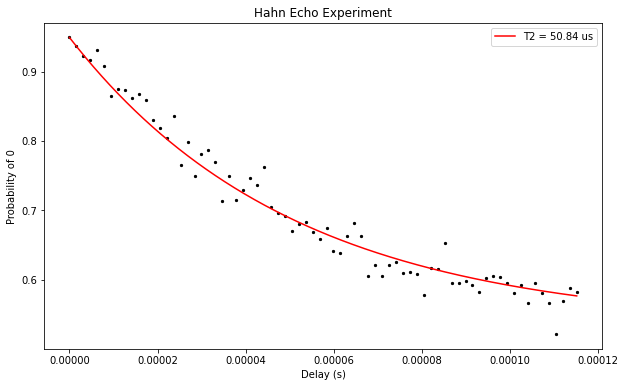

In [ ]:
def get_t2_values():
    t2_results = t2_job.result()
    t2_values = []
    results = t2_results.get_counts()
    for result in results:
        p0 = 0 if '0' not in result else result['0']/sum(result.values())
        t2_values.append(p0)
    return t2_values

def spin_echo_likelihood(t, T2, model_params):
    A, B = model_params
    return A*np.exp(-t/T2)+B

def fit_t2_likelihood(ts, values, model_params, smoothen_interpolation=True,
                      print_param=True):
    p0 = [t2_est]
    param,cov = curve_fit(lambda t,T2 : spin_echo_likelihood(t,T2,model_params),
                          ts, values, p0=p0,absolute_sigma=True)
    T2 = param[0]
    if print_param:
        err = np.sqrt(np.diag(cov))[0]
        print("Hahn echo likelihood curve fit:\n* T2 = %.6f ± %.6f us" % (T2*1e6,err*1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = spin_echo_likelihood(ts, T2, model_params)
    
    return T2,ts,ys

def show_t2_echoed(adapt_params = True):
    t2_values = get_t2_values()
    y0,ymin = [t2_values[0], t2_values[-1]] if adapt_params else [1,0.5]
    model_params = y0-ymin, ymin 
    if adapt_params:
        print("Used model parameters A=%.2f, B=%.2f. " % 
              (model_params[0],model_params[1]))
        # Use the last measurement for the offset only.
        times, t2_values = total_times[:-1], t2_values[:-1]
    else:
        times = total_times

    T2,extended_ts, ys = fit_t2_likelihood(times,t2_values,model_params)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(times, np.real(t2_values), color='black',s=5)
    plt.plot(extended_ts, ys, color='red', label=f"T2 = {T2*1e6:.2f} us")
    plt.xlabel('Delay (s)')
    plt.ylabel('Probability of 0')
    plt.title('Hahn Echo Experiment')
    plt.legend()
    plt.show()

show_t2_echoed()

### Comparing the curve fit to the inference results

Used model parameters A=0.42, B=0.53. 
Hahn echo likelihood curve fit:
* T2 = 50.841642 ± 47.167559 us


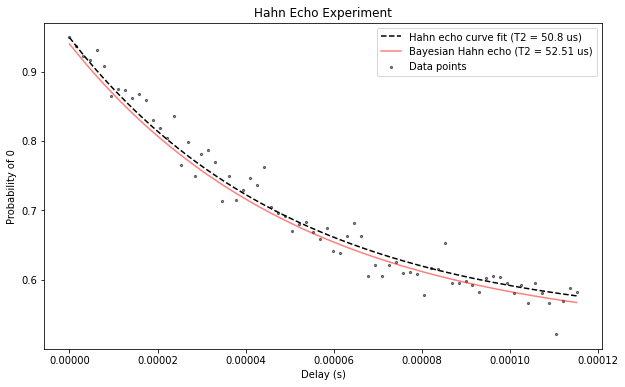

In [ ]:
def compare_inference(inference_T2 = 52.51, A=0.42, B=0.52):
    t2_values = get_t2_values()
    y0,ymin = [t2_values[0], t2_values[-1]] if adapt_params else [1,0.5]
    model_params = y0-ymin, ymin 
    if adapt_params:
        print("Used model parameters A=%.2f, B=%.2f. " % 
              (model_params[0],model_params[1]))
        # Use the last measurement for the offset only.
        times, t2_values = total_times[:-1], t2_values[:-1]
    else:
        times = total_times

    T2,extended_ts, ys = fit_t2_likelihood(times, t2_values, model_params)
    y2s = spin_echo_likelihood(extended_ts,inference_T2*1e-6, [A,B])
    
    plt.figure(figsize=(10, 6))
    plt.scatter(times, np.real(t2_values), color='black',s=5,alpha=0.5,label='Data points')
    plt.plot(extended_ts, ys, color='black', linestyle='dashed',
             label=f"Hahn echo curve fit (T2 = {T2*1e6:.1f} us)")
    plt.plot(extended_ts, y2s, color='red', alpha=0.5, #linestyle='dashed',
             label=f"Bayesian Hahn echo (T2 = {inference_T2:.2f} us)")
    plt.xlabel('Delay (s)')
    plt.ylabel('Probability of 0')
    plt.title('Hahn Echo Experiment')
    plt.legend()
    plt.show()

compare_inference()

### Getting data for the inference


In [ ]:
tmin, tmax = 0.4e-6, 2*t2_est
nsched = 75; nshots = 20; runs = 10

adapt_params = True 
adapt_params_obj = ((0,4*t2_est),512) if adapt_params else None

rand = False
if rand:
  times = np.array([random.uniform(tmin,tmax) for i in range(nsched)])
else:
  times = np.linspace(tmin, tmax, nsched)

extra_info = ['rand' if rand else '', 'h' if adapt_params else '']
extras = len(extra_info)
if extras > 0:
  extra_info = ("(%s)" % ','.join(filter(lambda s: len(s)>0, extra_info)))

filename_start = ("%s_spin_echo_data%s_t∈[%.1f,%.1f[T2_est=%d_sched=%d_shots=%d" 
                  % (configuration.backend_name[5:],
                     extra_info,
                     tmin*1e6,
                     tmax*1e6,
                     t2_est*1e6,
                     nsched,
                     nshots))

collect_data(run_Hahn_echoes, times, runs, nshots, filename_start, 
             adapt_params_obj = adapt_params_obj)

/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


Spin echo job ID: '60c264ce5093ce81b56be862' [run_spin_echo_job]
Job Status: job has successfully run
> Run 0.
Spin echo job ID: '60c264ec06f51a5d2f49f9e2' [run_spin_echo_job]
> Run 1.
Spin echo job ID: '60c264f1a5006847f1804131' [run_spin_echo_job]
> Run 2.
Spin echo job ID: '60c264f79e6f518101ee71d0' [run_spin_echo_job]
> Run 3.
Spin echo job ID: '60c264fc080a757f4c213ad0' [run_spin_echo_job]
> Run 4.
Spin echo job ID: '60c26501a500681708804132' [run_spin_echo_job]
> Run 5.
Spin echo job ID: '60c265054f8f11631b81e565' [run_spin_echo_job]
> Run 6.
Spin echo job ID: '60c2650a4f8f114dd081e566' [run_spin_echo_job]
> Run 7.
Spin echo job ID: '60c26510076a53255cf0f04c' [run_spin_echo_job]
> Run 8.
Spin echo job ID: '60c265152a560573c909fa29' [run_spin_echo_job]
> Run 9.
Spin echo job ID: '60c2651aa5006866a4804135' [run_spin_echo_job]
Job Status: job has successfully run
Run 0 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 1 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 2 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 3 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 4 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 1), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 5 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 6 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 1), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 7 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 1), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 8 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 1), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 9 data vector (length 1501):  [('params', (0.423828125, 0.51953125)), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 1), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (0.39999999999999997, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674, 0), (1.9508224721719674

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## <a name="T1"></a>Performing an experiment to get the energy relaxation time T1

In [ ]:
def get_T1_schedules(times):
    # The actual delays will be half as long as the total evolution times
    #(one after each of the first 2 pulses). Also need to convert to backend 
    #time units/samples.
    with pulse.build(backend):
      total_samples = pulse.builder.seconds_to_samples(times)
    delays = np.array([get_closest_multiple_of_16(nsamples) 
                       for nsamples in total_samples])
    
    mq = pulse.MeasureChannel(q)
    t1_schedules = []
    for i,delay in enumerate(delays):
        with pulse.build(backend,default_alignment='sequential', 
                          name=f"Delay no. {i}") as schedule:
          pulse.x(q) # Pi rotation.
          pulse.delay(delay,mq)
          pulse.measure(q)  
        t1_schedules.append(schedule)     

    return t1_schedules 

def run_T1_experiment(times,nshots=512,monitor=True):
    t1_schedules = get_T1_schedules(times)
    t1_experiment = backend.run(t1_schedules,
                            meas_level=2,
                            shots=nshots)

    ID = t1_experiment.job_id()
    print(f"T1 job ID: \'{ID}\' [run_spin_echo_job]")
    if monitor:
        job_monitor(t1_experiment)
    return(t1_experiment)

tmin, tmax = 20e-6, 3*t1_est
times = np.linspace(tmin, tmax, 75)
run_again = False
if run_again:
    t1_job = run_T1_experiment(times)
else:
    times = np.linspace(0, 3*48.6e-6, 75)
    t1_job = backend.retrieve_job('60b9121ae6e6410d342ec95c')

#print(t1_est)

### Fitting a curve

T1 likelihood curve fit:
* T1 = 67.234490 ± 25.564134 us


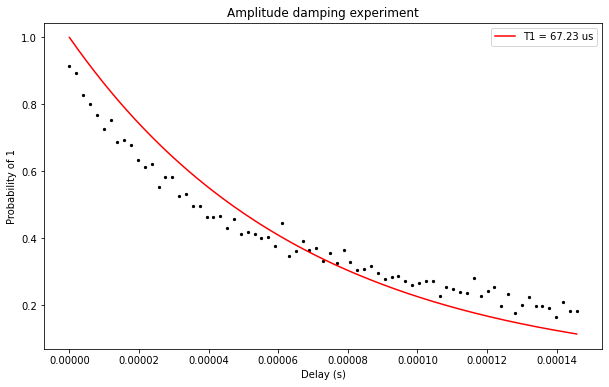

In [ ]:
def get_t1_values():
    t1_results = t1_job.result(timeout=120)
    t1_values = []
    results = t1_results.get_counts()
    for result in results:
        p1 = 0 if '1' not in result else result['1']/sum(result.values())
        t1_values.append(p1)
    return t1_values

def T1_likelihood(t, T1):
    return np.exp(-t/T1)

def fit_t1_likelihood(ts, values, smoothen_interpolation=True,print_param=True):
    p0 = [t1_est]
    param,cov = curve_fit(lambda t,T1: T1_likelihood(t,T1),ts, values,p0=p0,
                          absolute_sigma=True)
    T1 = param[0]
    if print_param:
        err = np.sqrt(np.diag(cov))[0]
        print("T1 likelihood curve fit:\n* T1 = %.6f ± %.6f us" % (T1*1e6,err*1e6))

    # Return also y-coordinate data for plotting.
    if smoothen_interpolation:
        ts=np.linspace(min(ts),max(ts),1000)
    ys = T1_likelihood(ts, T1)
    
    return T1,ts,ys

def show_t1_echoed():
    t1_values = get_t1_values()
    T1,extended_ts, ys = fit_t1_likelihood(times,t1_values)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(times, np.real(t1_values), color='black',s=5)
    plt.plot(extended_ts, ys, color='red', label=f"T1 = {T1*1e6:.2f} us")
    plt.xlabel('Delay (s)')
    plt.ylabel('Probability of 1')
    plt.title('Amplitude damping experiment')
    plt.legend()
    plt.show()

show_t1_echoed()

### Comparing the curve fit to the inference results

T1 likelihood curve fit:
* T1 = 67.234490 ± 25.564134 us


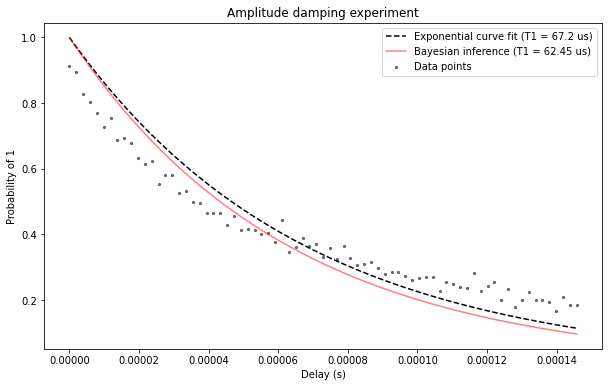

In [ ]:
def compare_inference(inference_T1 = 62.45):
    t1_values = get_t1_values()
    T1,extended_ts, ys = fit_t1_likelihood(times,t1_values)
    y2s = T1_likelihood(extended_ts,inference_T1*1e-6)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(times, np.real(t1_values), color='black',s=5,alpha=0.5,label='Data points')
    plt.plot(extended_ts, ys, color='black', linestyle='dashed',
             label=f"Exponential curve fit (T1 = {T1*1e6:.1f} us)")
    plt.plot(extended_ts, y2s, color='red', alpha=0.5, #linestyle='dashed',
             label=f"Bayesian inference (T1 = {inference_T1:.2f} us)")
    plt.xlabel('Delay (s)')
    plt.ylabel('Probability of 1')
    plt.title('Amplitude damping experiment')
    plt.legend()
    plt.show()

compare_inference()

### Getting data for the inference

In [ ]:
tmin, tmax = 1e-6, t1_est
nsched = 75; nshots = 20; runs = 10
rand = False
if rand:
  times = np.array([random.uniform(tmin,tmax) for i in range(nsched)])
else:
  times = np.linspace(tmin, tmax, nsched)

filename_start = configuration.backend_name[5:] + '_amplitude_damping_data[' + \
    str(round(tmin*1e6*2,1)) + ',' +  str(round(tmax*1e6)) + '[' +           \
    'T1_est=' + str(round(t1_est*1e6))  + ('(rand)' if rand else '') +         \
    '_sched=' + str(nsched) + '_nshots=' + str(nshots)

collect_data(run_T1_experiment, times, runs, nshots, filename_start)

> Run 0.


/usr/local/lib/python3.7/dist-packages/qiskit/compiler/assembler.py:310: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  "used instead of 'rep_time'.", RuntimeWarning)


T1 job ID: '60b8f8c09af47d4fc82d2f56' [run_spin_echo_job]
> Run 1.
T1 job ID: '60b8f8c16b8ea854f591063a' [run_spin_echo_job]
> Run 2.
T1 job ID: '60b8f8c2e6e64164402ec7f6' [run_spin_echo_job]
> Run 3.
T1 job ID: '60b8f8c39af47d2ba32d2f57' [run_spin_echo_job]
> Run 4.
T1 job ID: '60b8f8c5be6c304b990350f8' [run_spin_echo_job]
Job Status: job has successfully run
Run 0 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b9111bf120a70742b8f81d' [run_spin_echo_job]
Job Status: job has successfully run
Run 1 data vector (length 1500):  [(1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b911266035e62dbd5b8d1e' [run_spin_echo_job]
Job Status: job has successfully run
Run 2 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b911326b8ea832e291077d' [run_spin_echo_job]
Job Status: job has successfully run
Run 3 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b9113e0180475ba4916932' [run_spin_echo_job]
Job Status: job has successfully run
Run 4 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

T1 job ID: '60b9114a018047c75d916934' [run_spin_echo_job]
Job Status: job has successfully run
Run 5 data vector (length 1500):  [(1.0, 1), (1.0, 0), (1.0, 0), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 6 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 7 data vector (length 1500):  [(1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 8 data vector (length 1500):  [(1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Job Status: job has successfully run
Run 9 data vector (length 1500):  [(1.0, 1), (1.0, 0), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.0, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 0), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (1.6444332319087713, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 0), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.2888664638175427, 1), (2.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>